In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt               

In [2]:
dataset = dgl.data.CSVDataset('../../Dati/Dataset_otto_classi/')
dataset

Done loading data from cached files.


Dataset("Dataset_otto_classi", num_graphs=2276, save_path=../../Dati/Dataset_otto_classi/Dataset_otto_classi)

In [3]:
numer_class = []
a = 0
b = 0 
c = 0
d = 0
e = 0
f = 0
gg = 0
h = 0
for g, i in dataset:
    if i["label"].item() not in numer_class:
        numer_class.append(i["label"].item())
    if i["label"].item() == 0:
        a += 1
    elif i["label"].item() == 1:
        b += 1
    elif i["label"].item() == 2:
        c += 1
    elif i["label"].item() == 3:
        d += 1
    elif i["label"].item() == 4:
        e += 1
    elif i["label"].item() == 5:
        f += 1
    elif i["label"].item() == 6:
        gg += 1
    elif i["label"].item() == 7:
        h += 1

print(a, b, c, d, e, f, gg, h, (a+b+c+d+e+f+gg+h))
print(len(numer_class))

293 284 295 298 294 291 221 300 2276
8


In [4]:
dim_nfeats = 2
gclasses = len(numer_class)

In [5]:
size_batch = len(numer_class)*2
size_batch

16

In [6]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size= size_batch, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size= size_batch, drop_last=False)

In [7]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=2979, num_edges=101804,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), {'label': tensor([7., 4., 1., 6., 1., 5., 4., 2., 4., 6., 4., 3., 7., 5., 2., 1.])}]


In [8]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([ 55, 263,  96,  50, 217, 145, 367, 250, 351,  40, 256, 129, 144, 170,
        231, 215])
Number of edges for each graph element in the batch: tensor([  812, 10200,  1674,  1430,  6962,  3318, 13978,  9542, 14056,  1072,
         9958,  4358,  4448,  4530,  8506,  6960])
The original graphs in the minibatch:
[Graph(num_nodes=55, num_edges=812,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=263, num_edges=10200,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=96, num_edges=1674,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=50, num_edges=1430,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=217, num_edges=6962,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.fl

In [9]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [10]:
if gclasses == 2:
    num_of_epoches = 200
elif gclasses >= 2:
    num_of_epoches = 1000

In [11]:
# Create the model with given dimensions
loss_scores = {}
controllo = []
min_valore = 0.45

model = GCN(dim_nfeats, 128, gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



for epoch in range(num_of_epoches):
    print("Epoca: ", epoch)
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['label'].float())
        loss = F.cross_entropy(pred, labels['label'].long())
        #print("epoca: ", epoch, loss)
        optimizer.zero_grad()
        #print(optimizer)
        loss.backward()
        #print(loss)
        optimizer.step()
        #print(optimizer)
    print("   Loss -> ", loss.item())
    loss_scores[epoch] = loss.item()
    """if loss.item() < 0.4 and epoch >= 400:
        break"""
    if loss.item() < min_valore:
        controllo.append((epoch, loss.item()))
    

Epoca:  0


/Applications/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


   Loss ->  2.2198190689086914
Epoca:  1
   Loss ->  2.1257357597351074
Epoca:  2
   Loss ->  2.029381036758423
Epoca:  3
   Loss ->  2.049492835998535
Epoca:  4
   Loss ->  2.094172477722168
Epoca:  5
   Loss ->  2.02917742729187
Epoca:  6
   Loss ->  1.9620498418807983
Epoca:  7
   Loss ->  2.0260069370269775
Epoca:  8
   Loss ->  1.9370440244674683
Epoca:  9
   Loss ->  2.0167644023895264
Epoca:  10
   Loss ->  1.7751480340957642
Epoca:  11
   Loss ->  1.7846145629882812
Epoca:  12
   Loss ->  1.870073676109314
Epoca:  13
   Loss ->  1.8790160417556763
Epoca:  14
   Loss ->  1.7680444717407227
Epoca:  15
   Loss ->  1.8789185285568237
Epoca:  16
   Loss ->  1.6300350427627563
Epoca:  17
   Loss ->  2.0866167545318604
Epoca:  18
   Loss ->  1.7685514688491821
Epoca:  19
   Loss ->  1.6902971267700195
Epoca:  20
   Loss ->  1.6260462999343872
Epoca:  21
   Loss ->  1.7550302743911743
Epoca:  22
   Loss ->  1.8776063919067383
Epoca:  23
   Loss ->  1.829443097114563
Epoca:  24
   Loss 

   Loss ->  1.7601613998413086
Epoca:  196
   Loss ->  2.0370092391967773
Epoca:  197
   Loss ->  1.720346450805664
Epoca:  198
   Loss ->  2.0844738483428955
Epoca:  199
   Loss ->  1.690145492553711
Epoca:  200
   Loss ->  1.5709165334701538
Epoca:  201
   Loss ->  1.794754981994629
Epoca:  202
   Loss ->  1.8005180358886719
Epoca:  203
   Loss ->  1.994954228401184
Epoca:  204
   Loss ->  1.4420348405838013
Epoca:  205
   Loss ->  1.518640398979187
Epoca:  206
   Loss ->  1.482526183128357
Epoca:  207
   Loss ->  1.3463793992996216
Epoca:  208
   Loss ->  1.4164503812789917
Epoca:  209
   Loss ->  1.5526504516601562
Epoca:  210
   Loss ->  1.6216611862182617
Epoca:  211
   Loss ->  1.4312430620193481
Epoca:  212
   Loss ->  1.6151986122131348
Epoca:  213
   Loss ->  1.2968968152999878
Epoca:  214
   Loss ->  1.585334300994873
Epoca:  215
   Loss ->  1.390034556388855
Epoca:  216
   Loss ->  1.4063667058944702
Epoca:  217
   Loss ->  1.1180833578109741
Epoca:  218
   Loss ->  1.52685

   Loss ->  1.7244778871536255
Epoca:  388
   Loss ->  1.5543843507766724
Epoca:  389
   Loss ->  1.3146766424179077
Epoca:  390
   Loss ->  1.8487787246704102
Epoca:  391
   Loss ->  1.6273607015609741
Epoca:  392
   Loss ->  1.7351021766662598
Epoca:  393
   Loss ->  1.7429198026657104
Epoca:  394
   Loss ->  1.4215506315231323
Epoca:  395
   Loss ->  2.0274083614349365
Epoca:  396
   Loss ->  1.6440180540084839
Epoca:  397
   Loss ->  1.904417872428894
Epoca:  398
   Loss ->  1.3562997579574585
Epoca:  399
   Loss ->  1.4822849035263062
Epoca:  400
   Loss ->  1.7065672874450684
Epoca:  401
   Loss ->  1.6235370635986328
Epoca:  402
   Loss ->  1.493125557899475
Epoca:  403
   Loss ->  1.3768593072891235
Epoca:  404
   Loss ->  1.7847191095352173
Epoca:  405
   Loss ->  1.586386799812317
Epoca:  406
   Loss ->  1.6562398672103882
Epoca:  407
   Loss ->  1.6072373390197754
Epoca:  408
   Loss ->  1.9552960395812988
Epoca:  409
   Loss ->  1.3064717054367065
Epoca:  410
   Loss ->  2.

   Loss ->  1.353243350982666
Epoca:  580
   Loss ->  1.5222764015197754
Epoca:  581
   Loss ->  1.1386862993240356
Epoca:  582
   Loss ->  1.9096285104751587
Epoca:  583
   Loss ->  1.3745031356811523
Epoca:  584
   Loss ->  1.5962594747543335
Epoca:  585
   Loss ->  1.1739457845687866
Epoca:  586
   Loss ->  1.5453648567199707
Epoca:  587
   Loss ->  1.7611554861068726
Epoca:  588
   Loss ->  1.459290862083435
Epoca:  589
   Loss ->  1.5164765119552612
Epoca:  590
   Loss ->  1.285676121711731
Epoca:  591
   Loss ->  1.4166194200515747
Epoca:  592
   Loss ->  1.6640838384628296
Epoca:  593
   Loss ->  2.037142515182495
Epoca:  594
   Loss ->  1.5382198095321655
Epoca:  595
   Loss ->  1.0793839693069458
Epoca:  596
   Loss ->  1.5767511129379272
Epoca:  597
   Loss ->  1.787092685699463
Epoca:  598
   Loss ->  1.5044126510620117
Epoca:  599
   Loss ->  1.8238352537155151
Epoca:  600
   Loss ->  1.4943875074386597
Epoca:  601
   Loss ->  1.0307692289352417
Epoca:  602
   Loss ->  1.14

   Loss ->  1.1940869092941284
Epoca:  772
   Loss ->  1.7575602531433105
Epoca:  773
   Loss ->  3.037494421005249
Epoca:  774
   Loss ->  1.5369421243667603
Epoca:  775
   Loss ->  1.5472255945205688
Epoca:  776
   Loss ->  1.3013910055160522
Epoca:  777
   Loss ->  1.7756577730178833
Epoca:  778
   Loss ->  1.7679551839828491
Epoca:  779
   Loss ->  1.4095133543014526
Epoca:  780
   Loss ->  1.3985859155654907
Epoca:  781
   Loss ->  1.9211114645004272
Epoca:  782
   Loss ->  1.8026409149169922
Epoca:  783
   Loss ->  1.6189064979553223
Epoca:  784
   Loss ->  1.7417587041854858
Epoca:  785
   Loss ->  1.8438879251480103
Epoca:  786
   Loss ->  1.872022032737732
Epoca:  787
   Loss ->  1.4397625923156738
Epoca:  788
   Loss ->  1.4610801935195923
Epoca:  789
   Loss ->  1.5576292276382446
Epoca:  790
   Loss ->  1.745456337928772
Epoca:  791
   Loss ->  1.5317115783691406
Epoca:  792
   Loss ->  1.304331660270691
Epoca:  793
   Loss ->  1.6773008108139038
Epoca:  794
   Loss ->  1.4

   Loss ->  1.6670030355453491
Epoca:  964
   Loss ->  1.3933883905410767
Epoca:  965
   Loss ->  1.9076727628707886
Epoca:  966
   Loss ->  2.0079634189605713
Epoca:  967
   Loss ->  1.2378183603286743
Epoca:  968
   Loss ->  1.6101740598678589
Epoca:  969
   Loss ->  1.6965702772140503
Epoca:  970
   Loss ->  1.7068899869918823
Epoca:  971
   Loss ->  1.3662443161010742
Epoca:  972
   Loss ->  1.9171723127365112
Epoca:  973
   Loss ->  1.8330202102661133
Epoca:  974
   Loss ->  1.7049833536148071
Epoca:  975
   Loss ->  1.0448999404907227
Epoca:  976
   Loss ->  1.3820222616195679
Epoca:  977
   Loss ->  1.675337791442871
Epoca:  978
   Loss ->  1.153030276298523
Epoca:  979
   Loss ->  1.8905342817306519
Epoca:  980
   Loss ->  1.6498154401779175
Epoca:  981
   Loss ->  1.570289969444275
Epoca:  982
   Loss ->  1.4405078887939453
Epoca:  983
   Loss ->  1.6328405141830444
Epoca:  984
   Loss ->  1.30826735496521
Epoca:  985
   Loss ->  1.8945344686508179
Epoca:  986
   Loss ->  1.57

In [12]:
print("Ultmia epoca ", epoch," con valore di loss ->", loss.item())

Ultmia epoca  999  con valore di loss -> 1.8599501848220825


In [13]:
for x in controllo:
    if x[1] < 0.45:
        print(x)

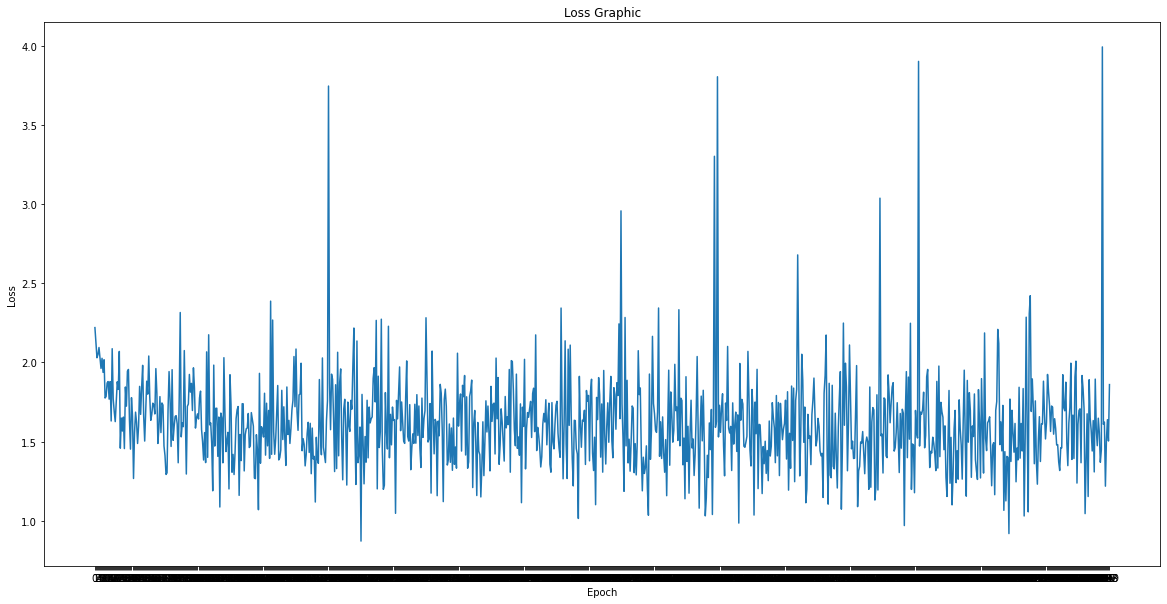

In [14]:
plt.figure(figsize = (20,10))
plt.plot(loss_scores.values())
plt.xticks(range(0,num_of_epoches,1), loss_scores.keys())
plt.title("Loss Graphic")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [15]:
num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['label'].float())
    num_correct += (pred.argmax(1) == labels['label'].long()).sum().item()
    num_tests += len(labels['label'].long())
    
    
print('Test accuracy:', num_correct / num_tests)

Test accuracy: 0.44298245614035087


## Analisi risultati
Con il dataset Binario l'accuratezza si aggira attorno al 0.9.
Con il dataset Multiplo il quale momentaneamente contiene 4 classi di grafi l'accuratezza si aggira attorno al 0.54.

## PROVE


Numero di nodi 16

batch = 10 epoche 1000 con soglia 400epoche e loss < 0.4 -> ***ACCURATEZZA OTTENUTA*** 0,61

batch = 8 epoche 5000  -> ***ACCURATEZZA OTTENUTA*** 0,61 con ultima loss -> 0.7

batch = 8 epoche 1000  -> ***ACCURATEZZA OTTENUTA*** 0,59 con ultima loss -> 0.87

batch = 8 epoche 1000  -> ***ACCURATEZZA OTTENUTA*** 0,63 con ultima loss -> 1.61





Numero di nodi 32

batch = 8 epoche 1000 ->  ***ACCURATEZZA OTTENUTA*** 0,62 con ultima loss ->  1.09


Numero di nodi 12

batch = 8 epoche 1000 ->  ***ACCURATEZZA OTTENUTA*** 0,62 con ultima loss ->   0.75







Numero di nodi 12 classificazione di sei classi 

batch = 12 epoche 1000 -> ***ACCURATEZZA OTTENUTA*** 0,42 con ultima loss ->  0.84